<a href="https://colab.research.google.com/github/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/Tutorials/Verification_by_abstraction_with_eran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial for Neural Network Verification with ERAN

---

*This tutorial gives an overview of the features of ERAN. \\
"ETH Robustness Analyzer for Neural Networks (ERAN) is a state-of-the-art sound, precise, scalable, and extensible analyzer based on abstract interpretation for the complete and incomplete verification" (for more details see their [repo](https://github.com/eth-sri/eran)). \\
First, we will use the example of a neural network trained on the IRIS dataset to show how abstract verification can be performed using zonotopes. For this purpose, a network is first trained on the data, then saved in ONNX format and then verified with ERAN. \\
Second, we try to verifiy the **robustness** of a classification Network trained on the MNIST dataset.*

Important Links:
- [ERANs Github Repo](https://github.com/eth-sri/eran)
- [ERANs documentation](https://files.sri.inf.ethz.ch/eran/docs/eran_manual.pdf)

---

![img](https://raw.githubusercontent.com/eth-sri/eran/master/overview.png)

# Installation

First we need to install some required packages. \\
(We are using a fork of ERAN here, because of a bug in their code.)

In [1]:
%%capture
%%bash

git clone https://github.com/DDiekmann/eran.git

sudo apt install m4
sudo apt install build-essential
sudo apt install autoconf
sudo apt install libtool
sudo apt install texlive-latex-base

cd eran
sudo bash ./install.sh
pip install -r requirements.txt

# Imports

Next we need to import the required libraries.

In [2]:
%%capture

%pip install onnx onnxruntime

import torch
from torch import nn
import numpy as np
import torch.onnx
import sys

import matplotlib.pyplot as plt

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/iris_trainer.py'}
import iris_trainer

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/plots.py'}
import plots

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/zonotpy/main/src/zonotope.py'}
from zonotope import zono

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/zonotpy/main/src/interval_abstraction.py'}
import interval_abstraction as ia

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/zonotpy/main/src/nn_functions.py'}
import nn_functions as zf

# Abstract verification of a NN trained on IRIS dataset
In this section we will first define a neural network and train it on the [IRIS dataset](https://archive.ics.uci.edu/ml/datasets/iris). This will be saved in ONNX format. \
Then we define a zonotope for abstract verification of the network with ERAN. \
The verification will then be performed using ERAN on the network with the defined zonotope.

## Definition of a Neural Network
We define a network with one linear layer and ReLU as activation function. 

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, number_of_neurons):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, output_dim),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

## Training
The model is then trained on the iris dataset.

In [4]:
names, feature_names, X, y, X_scaled, X_train, X_test, y_train, y_test = iris_trainer.load_dataset()

model = iris_trainer.train_model(
    NeuralNetwork(input_dim=X_train.shape[1], output_dim=3, number_of_neurons=10), 
    epochs=100, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test)

Shape of X (data): (150, 4)
Shape of y (target): (150,) int64
Example of x and y pair: [5.1 3.5 1.4 0.2] 0
Shape of training set X (120, 4)
Shape of test set X (30, 4)


100%|██████████| 100/100 [00:00<00:00, 279.60it/s]


Done. Accuracy: 0.8


## Visualization
The plots below show the target values and the classification made by the network on the data. 

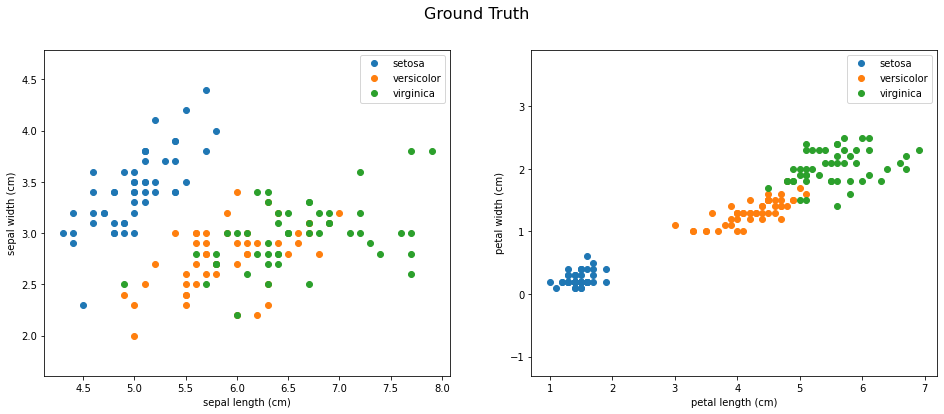

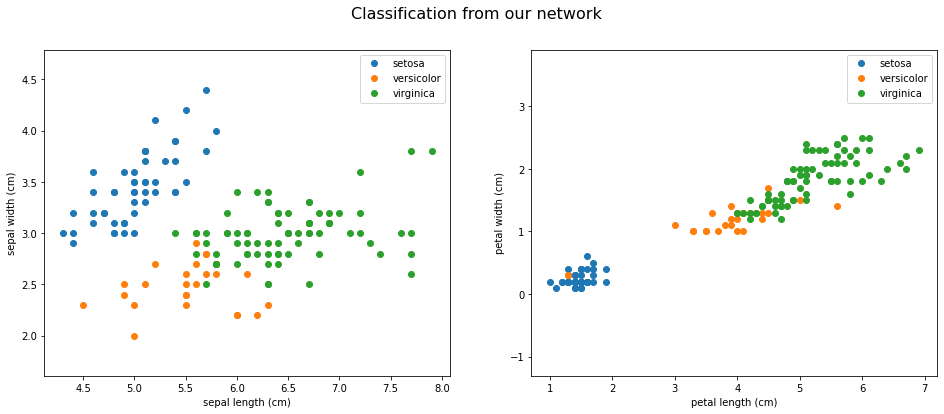

In [6]:
plots.show_plots(names, feature_names, X, y, title = 'Ground Truth')
plots.show_plots(names, feature_names, X, iris_trainer.predict(X_scaled, model), title = 'Classification from our network')

##TODO: raus oder erklären ? 

In [ ]:
model_parameters = [param.cpu().detach().numpy() for param in model.parameters()]
weights = model_parameters[0::2]
print(weights)
biases = model_parameters[1::2]
print(biases)

[array([[ 0.46685746,  0.32909364, -0.0282767 ,  0.54955614],
       [ 0.0172611 ,  0.02290974, -0.12281221,  0.41526493],
       [ 0.523001  , -0.478515  ,  0.5259937 ,  0.18491063],
       [ 0.2740115 ,  0.16081864,  0.14608881, -0.16564141],
       [ 0.28994012,  0.16899002, -0.3296092 ,  0.03140867],
       [-0.36010888,  0.08178136, -0.336214  ,  0.19957386],
       [-0.4992351 , -0.2792941 , -0.25612512, -0.41110736],
       [ 0.13729134, -0.4165266 ,  0.55389017, -0.32846192],
       [ 0.27337956,  0.18386434, -0.26979002,  0.19589926],
       [ 0.14065513,  0.34247053,  0.11684313, -0.09563331]],
      dtype=float32), array([[-4.0884161e-01, -1.7889611e-01, -3.3641985e-01,  1.9724481e-01,
         1.5924151e-01,  2.3257905e-01,  1.9868356e-01, -9.8084882e-02,
         1.9088311e-01, -1.5485901e-01],
       [-6.5957919e-02, -3.4132412e-01,  2.0124383e-01, -2.7870901e-02,
         1.7993769e-04, -1.6354296e-01,  1.4877616e-01, -9.6463762e-02,
        -2.3989472e-01, -2.6587668e-0

## Save the network
The network is then exported to a ONNX file.

In [7]:
model_filename = "iris_net.onnx"
dummy_input=torch.randn(1, 4)

# set model to eval mode
model.eval()

# create a dummy input in the shape of the input values
device = "cuda" if torch.cuda.is_available() else "cpu"
dummy_input = dummy_input.to(device)

torch.onnx.export(model,
                  dummy_input,
                  model_filename,
                  export_params=True,
                  verbose=False,
                  input_names=['data'],
                  output_names=['classification'],
                  )

## Definition of the zonotope
In order to use ERAN on a custom dataset and network, one needs to define the zonotope used in abstract verification. \
For an explanation on zonotopes see for example this [website](https://mitadmissions.org/blogs/entry/what-is-a-zonotope/). \
As described in the [manual of ERAN](https://files.sri.inf.ethz.ch/eran/docs/eran_manual.pdf), "the zonotope file
has two integers followed by a number of floats. The numbers can be separated by spaces, commas, or newlines. The first integer denotes the input dimension (e.g. 784 for MNIST).
The second integer is one plus the number of error terms of the zonotope. The number of floats is the two integers multiplied. Looking at an input of $i = [x0, x1, ... , xk]$, the file has all $\alpha$ values of the affine forms following each other."

We first want a small zonotope surrounding a point in the dataset. The chance, that we can successfully verify the robustness of the network here is probably high. \
Therefore, we take the first value of X and Y:

In [ ]:
print(X[0])
print(y[0])

[5.1 3.5 1.4 0.2]
0


As we can see, the input values are $[5.1, 3.5, 1.4, 0.2]$. The classification label for that input is $0$. 

Our zonotope is then defined as follows: 

In [8]:
%%writefile zonotype_example.txt
4
3
5.1 0.03 0.0
3.5 0.0 0.03
1.4 0.03 0.0 
0.2 0.0 0.03

Writing zonotype_example.txt


## Abstract verification with ERAN
Now we can run the verificator of ERAN on the model with use of the defined zonotope. 

In [9]:
%%bash
cd eran/tf_verify/

python3 . --netname ../../iris_net.onnx --zonotope ../../zonotype_example.txt --domain deepzono --debug true 

{'approx_k': True,
 'attack': False,
 'complete': False,
 'data_dir': None,
 'dataset': None,
 'debug': True,
 'delta': 0.3,
 'domain': 'deepzono',
 'epsfile': None,
 'epsilon': 0,
 'from_test': 0,
 'gamma': inf,
 'geometric': False,
 'geometric_config': None,
 'input_box': None,
 'k': 3,
 'logdir': None,
 'logname': None,
 'max_milp_neurons': 30,
 'mean': None,
 'n_milp_refine': 1,
 'netname': '../../iris_net.onnx',
 'normalized_region': True,
 'num_params': 0,
 'num_tests': None,
 'numproc': 2,
 'output_constraints': None,
 'partial_milp': 0,
 'quant_step': None,
 'refine_neurons': False,
 's': -2,
 'sparse_n': 70,
 'spatial': False,
 'specnumber': None,
 'std': None,
 'subset': None,
 't_norm': 'inf',
 'target': None,
 'timeout_complete': None,
 'timeout_final_lp': 100,
 'timeout_final_milp': 100,
 'timeout_lp': 1,
 'timeout_milp': 1,
 'use_default_heuristic': True,
 'use_milp': True,
 'vnn_lib_spec': None,
 'zonotope': '../../zonotype_example.txt'}
netname  ../../iris_net.onnx  eps

2022-07-16 17:59:00.125001: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
./optimizer.py:26: UserWarning: gpupoly not available.
  warnings.warn("gpupoly not available.")


## Another zonotope
In the next step, we select the same point as before as the centre of the zonotope, but make the zonotope significantly larger. What can we expect from the verification? 

In [ ]:
%%writefile zonotype_example.txt
4
3
5.1 4.0 0.0
3.5 0.0 4.0
1.4 4.0 0.0 
0.2 0.0 4.0

Overwriting zonotype_example.txt


In [ ]:
%%bash
cd eran/tf_verify/

python3 . --netname ../../iris_net.onnx --zonotope ../../zonotype_example.txt --domain deepzono --debug true 

{'approx_k': True,
 'attack': False,
 'complete': False,
 'data_dir': None,
 'dataset': None,
 'debug': True,
 'delta': 0.3,
 'domain': 'deepzono',
 'epsfile': None,
 'epsilon': 0,
 'from_test': 0,
 'gamma': inf,
 'geometric': False,
 'geometric_config': None,
 'input_box': '../../input_box.txt',
 'k': 3,
 'logdir': None,
 'logname': None,
 'max_milp_neurons': 30,
 'mean': None,
 'n_milp_refine': 1,
 'netname': '../../iris_net.onnx',
 'normalized_region': True,
 'num_params': 0,
 'num_tests': None,
 'numproc': 2,
 'output_constraints': None,
 'partial_milp': 0,
 'quant_step': None,
 'refine_neurons': False,
 's': -2,
 'sparse_n': 70,
 'spatial': False,
 'specnumber': None,
 'std': None,
 'subset': None,
 't_norm': 'inf',
 'target': None,
 'timeout_complete': None,
 'timeout_final_lp': 100,
 'timeout_final_milp': 100,
 'timeout_lp': 1,
 'timeout_milp': 1,
 'use_default_heuristic': True,
 'use_milp': True,
 'vnn_lib_spec': None,
 'zonotope': '../../zonotype_example.txt'}
netname  ../../i

2022-07-13 10:04:33.437799: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
./optimizer.py:26: UserWarning: gpupoly not available.
  warnings.warn("gpupoly not available.")


As we can see, the robustness of the network could not be verified with a larger zonotope. 

## Visualization (TODO)

In [ ]:
def relu(x):
  if x > 0: return x
  return 0

input_nodes = [5.1, 3.5, 1.4, 0.2]

def calculate_point(input_node):
  hidden_nodes = []
  for i in range(10):
    z = 0
    for w in range(4):
      z = z + (input_nodes[w] * weights[0][i][w])
    hidden_nodes.append(z)

  for i in range(10):
    hidden_nodes[i] = hidden_nodes[i] + biases[0][i]


  for i in range(10):
    hidden_nodes[i] = relu(hidden_nodes[i])


  output_nodes = []
  for i in range(3):
    z = 0
    for w in range(10):
      z = z + (hidden_nodes[w] * weights[1][i][w])
    output_nodes.append(z)

  for i in range(3):
    output_nodes[i] = output_nodes[i] + biases[1][i]

  return output_nodes

[-1.404938534903796, -0.947693692162117, 1.7137603030554713]


In [ ]:
model.forward(torch.Tensor(X[0]))

tensor([-1.4049, -0.9477,  1.7138], grad_fn=<AddBackward0>)

[(5.0, 5.199999999999999), (3.4, 3.6), (1.2999999999999998, 1.5), (0.1, 0.30000000000000004)]
[(-1.4854501551016916, -1.3287805380283988), (-1.0037260930949883, -0.8960536438917288), (1.6249111724772785, 1.8046099578540924)]
[[-1.40711535 -0.05037377 -0.02796104  0.        ]
 [-0.94988987  0.01084902 -0.0429872   0.        ]
 [ 1.71476057  0.05414659  0.0357028   0.        ]]
-1.3287805380283988
-1.4854501551016916
-0.8960536438917288
-1.0037260930949883
1.8046099578540924
1.6249111724772785


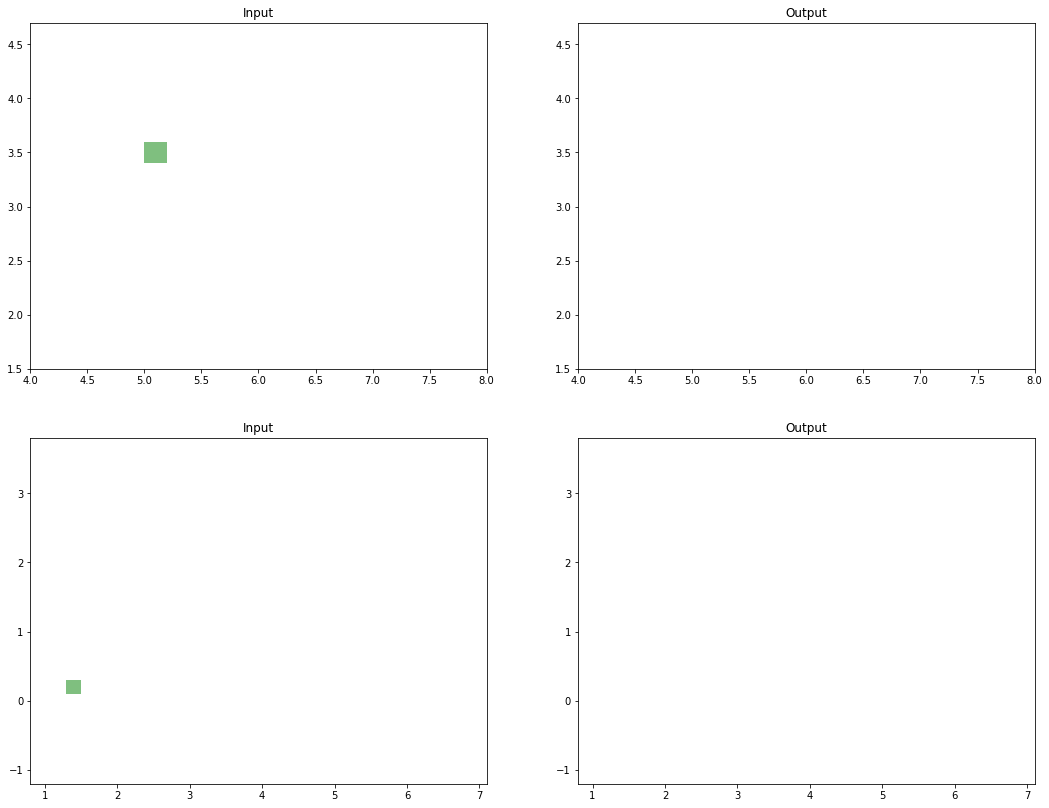

In [ ]:
def create_plot():
  fig, ax = plt.subplots(2, 2)

  fig.set_size_inches(18, 14)

  ax[0][0].set_title("Input")
  ax[0][0].set_xlim(4, 8)
  ax[0][0].set_ylim(1.5, 4.7)
  ax[0][1].set_title("Output")
  ax[0][1].set_xlim(4, 8)
  ax[0][1].set_ylim(1.5, 4.7)

  ax[1][0].set_title("Input")
  ax[1][0].set_xlim(0.8, 7.1)
  ax[1][0].set_ylim(-1.2, 3.8)
  ax[1][1].set_title("Output")
  ax[1][1].set_xlim(0.8, 7.1)
  ax[1][1].set_ylim(-1.2, 3.8)
  return fig, ax

fig, ax = create_plot()

input = zono(values = np.array([[5.1, 0.1, 0], [3.5, 0, 0.1], [1.4, 0.1, 0], [0.2, 0, 0.1]]))
print(input.to_intervals())
k1, k2 = input.split()
i1, i2 = k1.split()
i3, i4 = k2.split()

input_nodes = [i1, i2, i3, i4]

k1.visualize(shape=True, fig=fig, ax=ax[0][0])
k2.visualize(shape=True, fig=fig, ax=ax[1][0])

hidden_nodes = []
for i in range(10):
  z = zono()
  for w in range(4):
    z = z + (input_nodes[w] * weights[0][i][w])
  hidden_nodes.append(z)

for i in range(10):
  hidden_nodes[i] = hidden_nodes[i] + zono(values = np.array([[biases[0][i]]]))


for i in range(10):
  hidden_nodes[i] = zf.relu(hidden_nodes[i])


output_nodes = []
for i in range(3):
  z = zono()
  for w in range(10):
    z = z + (hidden_nodes[w] * weights[1][i][w])
  output_nodes.append(z)

for i in range(3):
  output_nodes[i] = output_nodes[i] + zono(values = np.array([[biases[1][i]]]))

output = output_nodes[0].combine(output_nodes[1]).combine(output_nodes[2])

print(output.to_intervals())
print(output)

print(output.upper_bound(1))
print(output.lower_bound(1))

print(output.upper_bound(2))
print(output.lower_bound(2))

print(output.upper_bound(3))
print(output.lower_bound(3))

plt.show()

# mnist

## define and train nn

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, number_of_neurons):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, output_dim),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
%%capture
train_dataloader, test_dataloader = mnist_trainer.load_mnist_dataset(batch_size=64)

In [ ]:
model = mnist_trainer.train_model(
    NeuralNetwork(input_dim=28*28, output_dim=10, number_of_neurons=20), 
    epochs=3, 
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    )

Epoch 1
-------------------------------


100%|██████████| 938/938 [00:11<00:00, 83.60it/s]


Test Error: 
 Accuracy: 91.6%, Avg loss: 0.281683 

Epoch 2
-------------------------------


100%|██████████| 938/938 [00:11<00:00, 85.09it/s]


Test Error: 
 Accuracy: 92.9%, Avg loss: 0.233787 

Epoch 3
-------------------------------


100%|██████████| 938/938 [00:11<00:00, 84.84it/s]


Test Error: 
 Accuracy: 93.8%, Avg loss: 0.205878 

Done!


export model

In [ ]:
model_filename = "mnist_net.onnx"
dummy_input=torch.randn(1, 28, 28)

# set model to eval mode
model.eval()

# create a dummy input in the shape of the input values
device = "cuda" if torch.cuda.is_available() else "cpu"
dummy_input = dummy_input.to(device)

torch.onnx.export(model,
                  dummy_input,
                  model_filename,
                  export_params=True,
                  verbose=False,
                  input_names=['image'],
                  output_names=['classification'],
                  )

## abstract verification

In [ ]:
%%bash

cd ERAN/tf_verify/

python3 . --netname ../../mnist_net.onnx --epsilon 0.1 --domain deepzono --dataset mnist

{'approx_k': True,
 'attack': False,
 'complete': False,
 'data_dir': None,
 'dataset': 'mnist',
 'debug': False,
 'delta': 0.3,
 'domain': 'deepzono',
 'epsfile': None,
 'epsilon': 0.1,
 'from_test': 0,
 'gamma': inf,
 'geometric': False,
 'geometric_config': None,
 'input_box': None,
 'k': 3,
 'logdir': None,
 'logname': None,
 'max_milp_neurons': 30,
 'mean': None,
 'n_milp_refine': 1,
 'netname': '../../mnist_net.onnx',
 'normalized_region': True,
 'num_params': 0,
 'num_tests': None,
 'numproc': 2,
 'output_constraints': None,
 'partial_milp': 0,
 'quant_step': None,
 'refine_neurons': False,
 's': -2,
 'sparse_n': 70,
 'spatial': False,
 'specnumber': None,
 'std': None,
 'subset': None,
 't_norm': 'inf',
 'target': None,
 'timeout_complete': None,
 'timeout_final_lp': 100,
 'timeout_final_milp': 100,
 'timeout_lp': 1,
 'timeout_milp': 1,
 'use_default_heuristic': True,
 'use_milp': True,
 'vnn_lib_spec': None,
 'zonotope': None}
netname  ../../mnist_net.onnx  epsilon  0.1  domai

2022-07-04 09:50:24.529822: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
./optimizer.py:26: UserWarning: gpupoly not available.
  warnings.warn("gpupoly not available.")


In [ ]:
%%bash

cd ERAN/tf_verify/

python3 . --netname ../../ffnnRELU__PGDK_w_0_3_6_500.onnx --epsilon 0.1 --domain deepzono --dataset mnist

In [ ]:
%%bash

cd ERAN/tf_verify/

python3 . --netname ../../mnist_net.onnx --epsilon 0.03 --domain deepzono --dataset mnist

In [ ]:
%%bash

cd ERAN/tf_verify/

python3 . --netname ../../mnist_net.onnx --epsilon 0.03 --domain deepzono --from_test 240 --dataset mnist

In [ ]:
%%bash
wget --no-cache --backups=1 {'https://github.com/eth-sri/eran/files/3653882/zonotope_example.txt'}

cd ERAN/tf_verify/

python3 . --netname ../../mnist_net.onnx --zonotope ../../zonotope_example.txt --domain deepzono --dataset mnist

{'approx_k': True,
 'attack': False,
 'complete': False,
 'data_dir': None,
 'dataset': 'mnist',
 'debug': False,
 'delta': 0.3,
 'domain': 'deepzono',
 'epsfile': None,
 'epsilon': 0,
 'from_test': 0,
 'gamma': inf,
 'geometric': False,
 'geometric_config': None,
 'input_box': None,
 'k': 3,
 'logdir': None,
 'logname': None,
 'max_milp_neurons': 30,
 'mean': None,
 'n_milp_refine': 1,
 'netname': '../../mnist_net.onnx',
 'normalized_region': True,
 'num_params': 0,
 'num_tests': None,
 'numproc': 2,
 'output_constraints': None,
 'partial_milp': 0,
 'quant_step': None,
 'refine_neurons': False,
 's': -2,
 'sparse_n': 70,
 'spatial': False,
 'specnumber': None,
 'std': None,
 'subset': None,
 't_norm': 'inf',
 'target': None,
 'timeout_complete': None,
 'timeout_final_lp': 100,
 'timeout_final_milp': 100,
 'timeout_lp': 1,
 'timeout_milp': 1,
 'use_default_heuristic': True,
 'use_milp': True,
 'vnn_lib_spec': None,
 'zonotope': '../../zonotope_example.txt'}


{https://github.com/eth-sri/eran/files/3653882/zonotope_example.txt}: Scheme missing.
2022-07-06 11:15:56.682168: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
./optimizer.py:26: UserWarning: gpupoly not available.
  warnings.warn("gpupoly not available.")
Traceback (most recent call last):
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "./__main__.py", line 427, in <module>
    zonotope = read_zonotope(zonotope_file)
  File "./read_zonotope_file.py", line 23, in read_zonotope
    assert os.path.isfile(zonotope_file), 'There exists no zonotope file.'
AssertionError: There exists no zonotope file.


In [ ]:
%%bash

cd ERAN/tf_verify/
python3 . --netname ../../mnist_net.onnx --dataset mnist --domain deeppoly --spatial --t-norm inf --delta 3

In [ ]:
%%bash

#wget --no-cache --backups=1 {'https://files.sri.inf.ethz.ch/eran/nets/onnx/mnist/mnist_relu_3_50.onnx'}

cd ERAN/tf_verify/

python3 . --netname ../../mnist_relu_3_50.onnx --epsilon 0.1 --domain deepzono --dataset mnist

In [ ]:
!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/eth-sri/deepg/master/code/examples/example1/config.txt'}

In [ ]:
%%bash

cd ERAN

set -e

cd gurobi912/linux64/src/build
sed -ie 's/^C++FLAGS =.*$/& -fPIC/' Makefile
make
cp libgurobi_c++.a ../../lib/
cp ../../lib/libgurobi90.so /usr/lib
cd ..

export GUROBI_HOME="$(pwd)/gurobi900/linux64"
export PATH="${PATH}:${GUROBI_HOME}/bin"
export CPATH="${CPATH}:${GUROBI_HOME}/include"
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/lib:${GUROBI_HOME}/lib

git clone https://github.com/eth-sri/deepg.git
cd deepg/code
mkdir build
make shared_object
cp ./build/libgeometric.so /usr/lib
cd ../..

export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/lib:/usr/lib

ldconfig

Footer

cd tf_verify/

python3 . --netname ../../mnist_net.onnx --geometric --geometric_config ../../config.txt --num_params 1 --dataset mnist